In [35]:
import os
import tensorflow as tf
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import numpy as np

In [36]:
print(f"Using Tensorflow {tf.__version__}")

Using Tensorflow 2.9.1


In [37]:
tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [278]:
import pandas as pd
train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"
fake_news = pd.read_csv(train_url)

In [279]:
fake_news.head()
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22449 entries, 0 to 22448
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  22449 non-null  int64 
 1   title       22449 non-null  object
 2   text        22449 non-null  object
 3   fake        22449 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 701.7+ KB


In [280]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [281]:
def make_dataset(dataset):
    #Getting rid of stop words in title and text
    dataset['text'] = dataset['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    dataset['title'] = dataset['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    #Vectorizing data
    #text = dataset['text'].apply(lambda x: convert_text_input(x))
    #title = dataset['title'].apply(lambda x: convert_text_input(x))
    #Constructing Dataset with two inputs(title, text) and one output (fake)
    final = tf.data.Dataset.from_tensor_slices(({"text": dataset['text'], "title": dataset['title']}, {"fake": dataset['fake']}))
    final = final.batch(100)
    #Constructing train, validation and test datasets
    #final = final.shuffle(10000, seed=12)
    
    train_size = int(.76 * len(list(final)))
    val_size = int(.2 * len(list(final)))

    train_ds = final.take(train_size)    
    val_ds = final.skip(train_size).take(val_size)
    test_ds = final.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = make_dataset(fake_news)

In [282]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

In [69]:
temp = [y for x, y in train_dataset]
labels_iterator = []
for x in temp:
    labels_iterator.extend(x['fake'].numpy())
fakecount, realcount = 0, 0
for x in labels_iterator:
    if x == 0:
        realcount += 1
    else:
        fakecount += 1
print(realcount)
print(fakecount)
#If this model was to always guess fake news, it would be accurate 52.58% of the time

8117
8932


In [312]:
import re
import string
#preparing a text vectorization layer for tf model
size_vocabulary = 2000

def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation 

title_vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500) 

title_vectorize_layer.adapt(train_dataset.map(lambda x, y: x["title"]))


In [131]:
train_dataset_title = train_dataset.map(lambda x, y: convert_text_input(x["title"]))
train_dataset_text = train_dataset.map(lambda x, y: convert_text_input(x["text"]))
train_dataset_fake = train_dataset.map(lambda x, y: y)
validation_dataset_title = validation_dataset.map(lambda x, y: convert_text_input(x["title"]))
validation_dataset_fake = validation_dataset.map(lambda x, y: y)
#temp1 = tf.data.Dataset.zip((train_dataset_title, train_dataset_text))
temp = tf.data.Dataset.zip((train_dataset_title, train_dataset_fake))
temp1 = tf.data.Dataset.zip((validation_dataset_title, validation_dataset_fake))

In [347]:
num_words = 2000  # Size of vocabulary obtained when preprocessing text data

title_input = tf.keras.Input(shape=(500,), dtype=tf.int32)  # Variable-length sequence of ints , name="title"
#text_input = tf.keras.Input(shape=(None,), name="text")  # Variable-length sequence of ints

# Embed each word in the title into a 64-dimensional vector (title_input)
title_features = tf.keras.layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
#text_features = tf.keras.layers.Embedding(num_words, 64)(text_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = tf.keras.layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
#text_features = tf.keras.layers.LSTM(32)(text_features)

# Merge all available features into a single large vector via concatenation
#x = tf.keras.layers.concatenate([title_features])
#x = tf.keras.layers.concatenate([title_features, text_features])

# Stick a logistic regression for priority prediction on top of the features
fake_pred = tf.keras.layers.Dense(1)(title_features)

# Instantiate an end-to-end model predicting both priority and department
model1 = tf.keras.Model(
    inputs=[title_input],
    outputs=[fake_pred]
)

In [348]:
inputs = tf.keras.Input(shape=(1, ), name = "title")
x = title_vectorize_layer(inputs)
outputs = model1(x)
model2 = tf.keras.Model(inputs, outputs)

In [349]:
model2.summary()

Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 title (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization_8 (TextV  (None, 500)              0         
 ectorization)                                                   
                                                                 
 model_53 (Functional)       (None, 1)                 226945    
                                                                 
Total params: 226,945
Trainable params: 226,945
Non-trainable params: 0
_________________________________________________________________


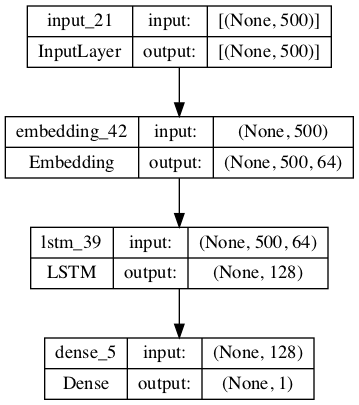

In [350]:
import graphviz
import pydot
utils.plot_model(model1, "multi_input_and_output_model.png", show_shapes=True)

In [356]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model2.compile(optimizer="adam", loss=loss_fn, metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) 

In [357]:
history1 = model2.fit(train_dataset, epochs=20, verbose=1, validation_dataset = validation_dataset)

Epoch 1/20


ValueError: Found unexpected losses or metrics that do not correspond to any Model output: dict_keys(['fake']). Valid mode output names: ['model_53']. Received struct is: {'fake': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=int64>}.

In [ ]:
#I tried to solve this error for 10+ hours and I couldn't figure it out
#I know I wont get any credit for this, but I wanted to submit it anyways because this
#was a lot of work and getting no credit doesn't seem fair. 